# Investigating Hybrid Strategies for Systematic Literature Review
**Experiment 2**

**Study**
  
  A systematic review on the use of Definition of Done on agile software development projects
  
  Silva, A., Araújo, T., Nunes, J., Perkusich, M.r, Dilorenzo, E., Almeida, H.r, Perkusich, A.
  
  21st International Conference on Evaluation and Assessment in Software Engineering, EASE 2017

In [1]:
%matplotlib inline

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2016
reload()
# !pip install matplotlib-venn

SVG = False

In [2]:
import statistics as s
from collections import Counter, deque
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

class FinalSelection(State):
    
    def __init__(self, state):
        self.state = state
    
    @property
    def log(self):
        return []
    
    @property
    def dot(self):
        result = ["digraph G {", '  rankdir="RL";', ""]
        actions = Counter()

        stack = deque([self.state])
        visited = {id(self.state)}
        while stack:
            current = stack.popleft()
            current.final_selected = {
                work for work in current.related 
                if int(getattr(work, "final_selected", 0))
            }
            current.seed_set = {
                work for work in current.related 
                if int(getattr(work, "seed_set", 0))
            }
            current.excel = {
                work for work in current.visited 
                if int(getattr(work, "planilha_{}2016".format(current.name), 0))
            }
            current.excel_selected = {
                work for work in current.related 
                if int(getattr(work, "planilha_{}2016".format(current.name), 0))
            }
            current.delta_selected = {}
            current.delta_seed_set = {}
            options = [
                (" visited", len(current.visited)),
                (" selected", len(current.related)),  #  ("WorkSnowball", len(current.related)),
                #("selected", len(current.final_selected)),
                #("seed_set", len(current.seed_set)),
            ]
            #if current.planilha:
            #    options.append((" planilha", len(current.planilha)))
            #    options.append((" planilha selected", len(current.planilha_selected)))
            #    options.append((" duplicados", len(current.visited - current.planilha)))
            
            #if current.name == "scopus2016":
            #    current.name = "Scopus"
                          
            result.append('  {0} [label="{0}\\n{1}"];'.format(
                current.name, 
                "\\n".join("{}: {}".format(key, value) for key, value in options)
            ))
            if current.previous:
                operation = current.previous[1]
                for element in current.previous[0]:
                    if operation == "union":
                        
                       # if current.name == "scopus2016":
                       #     current.name = "Scopus"
                                               
                        result.append('  {} -> {} [label="{}"];'.format(
                            current.name, element.name, operation
                        ))
                        
                        
                    else:
                        current.delta_selected = {
                            work for work in current.delta_related 
                            if int(getattr(work, "final_selected", 0))
                        }
                        current.delta_seed_set = {
                            work for work in current.delta_related 
                            if int(getattr(work, "seed_set", 0))
                        }
                        
                        options = [
                            (" visited", len(current.delta_visited)),
                            (" selected", len(current.delta_related)),
                            #("selected", len(current.delta_selected)),
                            #("seed_set", len(current.delta_seed_set)),
                        ]
                        
                       # if current.name == "scopus2016":
                       #     current.name = "Scopus"
                                        
                        result.append('  {} -> {} [label="{}\\n{}"];'.format(
                            current.name, element.name, operation,
                            "\\n".join("{}: {}".format(key, value) for key, value in options)
                        ))
                    if id(element) not in visited:
                        stack.append(element)
                        visited.add(id(element))
            result.append("")

        result.append("}")
        return '\n'.join(result)
    
    @property
    def draw(self):
        if SVG:
            return self._ipython_display_()
        from subprocess import Popen, PIPE as P
        from IPython.display import display
        bundle = {}

        dot = self.dot
        bundle['text/vnd.graphviz'] = dot

        try:
            kwargs = {} if os.name != 'nt' else {"creationflags": 0x08000000}
            p = Popen(['dot', '-T', "png"], stdout=P, stdin=P, stderr=P, **kwargs)
            image = p.communicate(dot.encode('utf-8'))[0]
            bundle['image/png'] = image
        except OSError as e:
            if e.errno != os.errno.ENOENT:
                raise

        bundle['text/plain'] = '\n'.join(map(str, self.log))
        display(bundle, raw=True)


def precision_recall(state, total, final, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", 
        "precision", "recall", "fmeasure", 
        "final_precision", "final_recall", "final_fmeasure", 
        "operation", "delta_related", "delta_visited", "delta_selected",
        "related", "visited", "final_selected",
        "excel", "excel_selected", "duplicated",
        "accumulated_precision", "accumulated_recall", "accumulated_fmeasure",
        "final_accumulated_precision", "final_accumulated_recall", "final_accumulated_fmeasure"
    ]]
    FinalSelection(state).dot
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        accumulated_recall = len(current.related) / len(total)
        recall = len(current.delta_related) / len(total)
        final_accumulated_recall = len(current.final_selected) / len(final)
        final_recall = len(current.delta_selected) / len(final)
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = float('nan')
        try:
            final_accumulated_precision = len(current.final_selected) / len(current.visited)
            final_precision = len(current.delta_selected) / len(current.delta_visited)
        except ZeroDivisionError:
            final_precision = float('nan')
        try:
            accumulated_fmeasure = s.harmonic_mean([accumulated_precision, accumulated_recall])
            fmeasure = s.harmonic_mean([precision, recall])
        except ZeroDivisionError:
            fmeasure = float('nan')
        try:
            final_accumulated_fmeasure = s.harmonic_mean([final_accumulated_precision, final_accumulated_recall])
            final_fmeasure = s.harmonic_mean([final_precision, final_recall])
        except ZeroDivisionError:
            final_fmeasure = float('nan')
        excel = {
            work for work in current.visited 
            if int(getattr(work, "planilha_{}2016".format(current.name), 0))
        }
        excel_selected = {
            work for work in current.related 
            if int(getattr(work, "planilha_{}2016".format(current.name), 0))
        } 
                    
        array.append([
            current.name,
            precision,
            recall,
            fmeasure,
            final_precision,
            final_recall,
            final_fmeasure,
            current.previous[1] if current.previous else "-",
            len(current.delta_related),
            len(current.delta_visited),
            len(current.delta_selected),
            len(current.related),
            len(current.visited),
            len(current.final_selected),
            len(excel),
            len(excel_selected),
            len(current.visited - excel) if excel else 0,
            accumulated_precision,
            accumulated_recall,
            accumulated_fmeasure,
            final_accumulated_precision,
            final_accumulated_recall,
            final_accumulated_fmeasure,
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

# Strategies

## Strategy 1 - Database Search (Search)

In [3]:
print ("\nTotal of selected studies = 16 (Seed Set) + 4 (Snowballing) =", len ({x for _, x in load_work_map_all_years() if x.category == "snowball"}))


Total of selected studies = 16 (Seed Set) + 4 (Snowballing) = 20


In [4]:
reload()
#TOTAL = {x for _, x in load_work_map_all_years() if getattr(x, "seed_set", 0)}
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

arraysearch = []
for listdl in ("scopus_search","springer_search", "wiley_search","sciencedirect_search","acm_search","webofscience_search","elcompendex_search" ):
    search_title = {x for _, x in load_work_map_all_years() if getattr(x, listdl, 0)}
    recall_title = (len(search_title) / len(TOTAL))
    dl_row = [listdl[:-7]] + [recall_title]
    arraysearch.append(dl_row)
    
#print (arraysearch)

strategy = Strategy(*busca("scopus2016", filter_function=filter_function)) # busca simples

state = strategy.initial
strategy.initial.visited

FinalSelection(state);


 Provenance Graph - Strategy 1 - Database Search (Search)


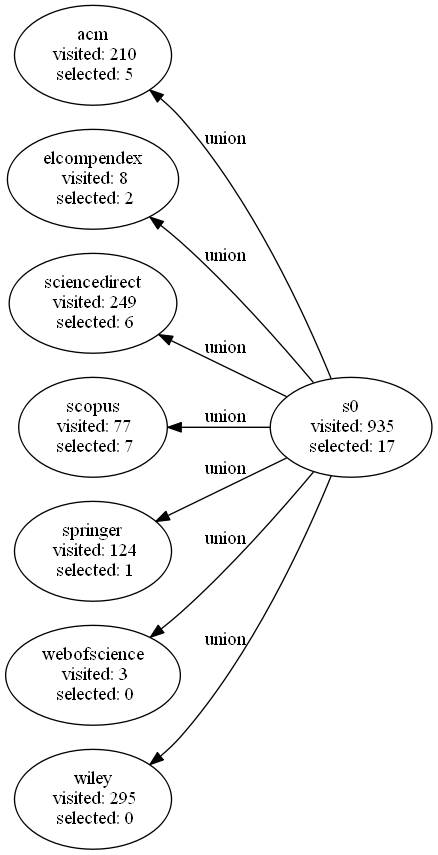

In [5]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl [:-4]    #ou dl [:-4].capitalize() = caps first 
        if union is None:
            union = strategy.initial.derive("union", name="s0") 
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

bibliotecas = ["acm2016", "elcompendex2016", "sciencedirect2016", "scopus2016", "springer2016", "webofscience2016", "wiley2016",]
strategy = busca_completa(bibliotecas, filter_function)
state = strategy.initial
final = FinalSelection(state)
print("\n \033[1mProvenance Graph - Strategy 1 - Database Search (Search)\033[0m")
final.draw

In [6]:
#{work
# for _, work in load_work_map_all_years()
# for bib in bibliotecas
# for bib2 in bibliotecas
# if bib != bib2
# if int(getattr(work, "planilha_{}".format(bib), 0))
# if int(getattr(work, "planilha_{}".format(bib2), 0))
#}

In [7]:
# salva o gráfico de proveniência no formato para incluir em pdf, word.
def salvar(state, arquivo):
    with open("{}.dot".format(arquivo), "w") as f:
        f.write(state.dot)
    !dot -Tsvg {arquivo}.dot -o {arquivo}.svg
    !inkscape -f {arquivo}.svg -e {arquivo}.png -d 300

In [8]:
#salvar(final, "E1final")

In [9]:
#strategy.initial.seed_set @ metakey_title
#strategy.initial.visited

In [10]:
array = []
name = "Search"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df = df.round(4)
df.columns = df.iloc[-1]
df = df.drop(df.index[[-1]])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
#df = df.drop(df.index[[-1,7]]) #exclude row first=-1 and last=7=s0
df

d_decimals = 4 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
        
df1 = df[["state","visited", "related", "precision", "recall", "fmeasure" ]]
df1.columns = ['Digital Library', 'Visited', 'Selected', 'Precision %', 'Recall %', 'F-Measure %']

df1 = df1.sort_values('Digital Library', ascending=True)

#print (df1.to_string(index=False))
#df1_style.hide_index()

df2 = df[["visited", "related","accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
df2.columns = ['Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']
df2 = df2.loc[df['state'] == 's0']


df1 = df1.drop(df.index[[-1,7]])

df2_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df2_style.hidden_index = True
df2_style.format({
    'Precision %': '{:,.2f}'.format,    'Recall %': '{:,.2f}'.format,    'F-Measure %': '{:,.2f}'.format,
})

dfE1 = df2_style
dfE1r =df1

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: gold' if v else '' for v in is_max]


import seaborn as sns
sns.set_style(style='white')  

cm = sns.light_palette("green", as_cmap=True)
#df2_style.background_gradient(cmap=cm, subset=['Precision %', 'Recall %', 'F-Measure %']).highlight_max(subset=['Precision %', 'Recall %', 'F-Measure %']).set_table_styles(([
#    dict(selector="th", props=[("text-align", "center")]),
#]))

df2_style.background_gradient(cmap=cm, subset=['Precision %', 'Recall %', 'F-Measure %']).set_table_styles(([
    dict(selector="th", props=[("text-align", "center")]),
]))
df2_style.apply(highlight_max, subset=['Precision %', 'Recall %', 'F-Measure %'])

df2_style.highlight_null(null_color='crimson')

def color_value_zero(val):
    color = 'green' if val == 0 else 'black'
    return 'color: %s' % color

df2_style.applymap(color_value_zero, subset=pd.IndexSlice[:, ['Precision %', 'Recall %', 'F-Measure %']])


print("\n\033[1mReport Strategy 1 - Database Search (Search) \033[0m")
print("\nTotal of selected studies in the SLR = ", len(TOTAL))
print("\nPrecision = Selected/ Visited")
print("Recall = Selected/ Total of selected studies in the SLR")
print("F-Measure = Harmonic Mean of Precision and Recall")
df2_style



Report Strategy 1 - Database Search (Search) 

Total of selected studies in the SLR =  20

Precision = Selected/ Visited
Recall = Selected/ Total of selected studies in the SLR
F-Measure = Harmonic Mean of Precision and Recall


Digital Library,Visited,Selected,Precision %,Recall %,F-Measure %
acm,210,5,2.38,25.00,4.35
elcompendex,8,2,25.00,10.00,14.29
sciencedirect,249,6,2.41,30.00,4.46
scopus,77,7,9.09,35.00,14.43
springer,124,1,0.81,5.00,1.39
webofscience,3,0,0.00,0.00,0.00
wiley,295,0,0.00,0.00,0.00


In [11]:
df.to_excel("estrategia1.xlsx")


  Bar Chart Strategy 1 


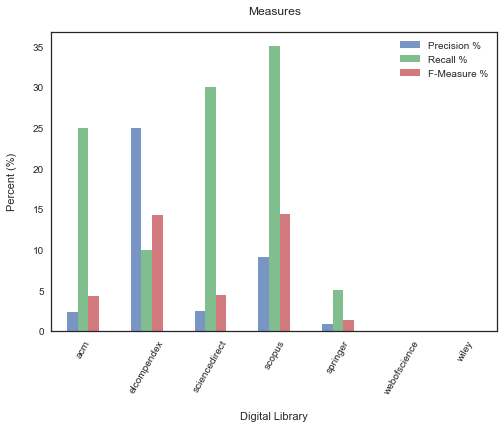

In [12]:
df1.plot.bar(y=['Precision %','Recall %','F-Measure %'], alpha=0.75, rot=60)
ax = plt.gca()
ax.set_title("Measures\n")
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.0, 1.0))
ax.set_xticklabels(df1['Digital Library'])
plt.xlabel("\nDigital Library")
plt.ylabel("Percent (%)\n")
print ('\n \033[1m Bar Chart Strategy 1 \033[0m')


  Bar Chart Strategy 1 


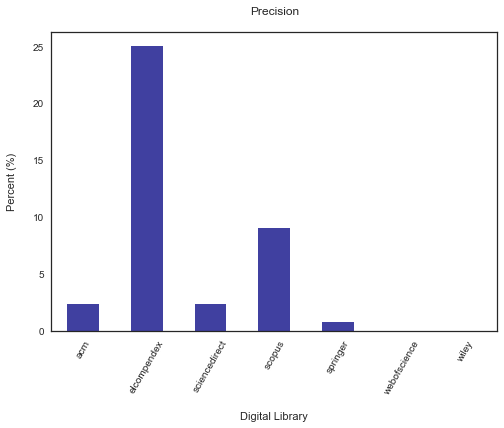

In [13]:
df1.plot.bar(y=['Precision %'], color="navy", alpha=0.75, rot=60)
ax = plt.gca()
ax.set_title("Precision\n")
ax.legend_.remove()
ax.set_xticklabels(df1['Digital Library'])
plt.xlabel("\nDigital Library")
plt.ylabel("Percent (%)\n")
print ('\n \033[1m Bar Chart Strategy 1 \033[0m')


  Bar Chart Strategy 1 


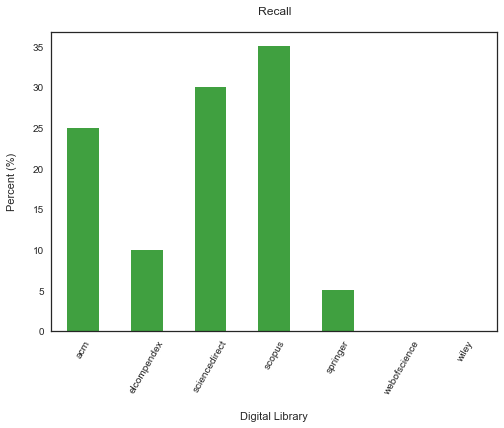

In [14]:
df1.plot.bar(y=['Recall %'], color="green", alpha=0.75, rot=60)
ax = plt.gca()
ax.set_title("Recall\n")
ax.legend_.remove()
ax.set_xticklabels(df1['Digital Library'])
plt.xlabel("\nDigital Library")
plt.ylabel("Percent (%)\n")
print ('\n \033[1m Bar Chart Strategy 1 \033[0m')


  Bar Chart Strategy 1 


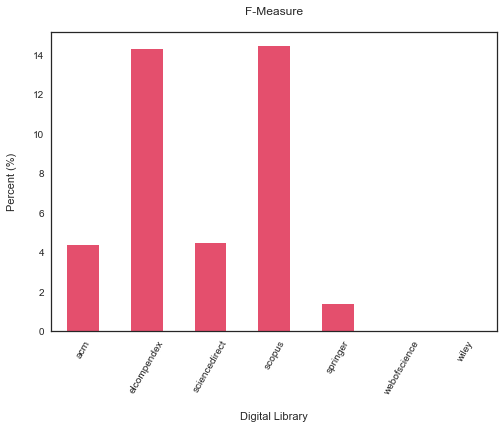

In [15]:
df1.plot.bar(y=['F-Measure %'], color="crimson", alpha=0.75, rot=60)
ax = plt.gca()
ax.set_title("F-Measure\n")
ax.legend_.remove()
ax.set_xticklabels(df1['Digital Library'])
plt.xlabel("\nDigital Library")
plt.ylabel("Percent (%)\n")
ax.grid(False)
print ('\n \033[1m Bar Chart Strategy 1 \033[0m')

In [16]:

dfa = pd.DataFrame(array)
df1 = dfa[[0, 2, 1, 7, 8, 9]].copy() 
df1.columns = ['Strategy','Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']

d_decimals = 4    
for coluna in ['Precision %', 'Recall %', 'F-Measure %']:
    df1[coluna] = df1[coluna].apply(lambda x: round(x,d_decimals)*100)

df2_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df2_style.format({
    'Precision %': '{:,.2f}'.format,    'Recall %': '{:,.2f}'.format,    'F-Measure %': '{:,.2f}'.format,
})

print("\n \033[1mReport Strategy 1 - Measures of Strategy - Union of all digital libraries (accumulated) \033[0m")
df2_style.hidden_index = True
df2_style



 Report Strategy 1 - Measures of Strategy - Union of all digital libraries (accumulated) 


Strategy,Visited,Selected,Precision %,Recall %,F-Measure %
Search,935,17,1.82,85.00,3.56


In [17]:

df3 = df[["state","visited", "related", "excel", "excel_selected", "duplicated"]]
df3.columns = ['Digital Library', 'Visited', 'Selected', 'Excel', 'Excel Selected', 'Duplicated']
df3 = df3.drop(df.index[[-1,7]]) #remove ultima linha que contem o state s0.

df3 = df3.sort_values('Digital Library', ascending=True)

df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df3_style.hidden_index = True
print("\n\033[1mReport Strategy 1 - Total of papers retrieved from Excel and Duplicates.\033[0m")
print("\nVisited = Excel + Duplicates")
print("Selected = Papers selected in the SLR")
print("Excel =  Papers retrieved from Excel provided by authors")
print("Excel Selected =  Papers selected in the SLR and retrieved from Excel provided by authors")
print("Duplicated =  Papers identified as duplicate")

df3_style


Report Strategy 1 - Total of papers retrieved from Excel and Duplicates.

Visited = Excel + Duplicates
Selected = Papers selected in the SLR
Excel =  Papers retrieved from Excel provided by authors
Excel Selected =  Papers selected in the SLR and retrieved from Excel provided by authors
Duplicated =  Papers identified as duplicate


Digital Library,Visited,Selected,Excel,Excel Selected,Duplicated
acm,210,5,210,5,0
elcompendex,8,2,1,0,7
sciencedirect,249,6,245,5,4
scopus,77,7,68,7,9
springer,124,1,115,0,9
webofscience,3,0,3,0,0
wiley,295,0,294,0,1



  Bar Chart Publications Type - Strategy 1 
 


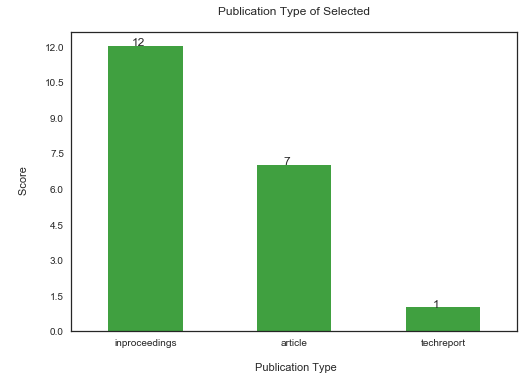

In [18]:
lista = [work.entrytype for work in TOTAL] # in state.related
df = pd.DataFrame (lista)

ax = df.apply(pd.value_counts).plot(kind="bar", color = 'green',legend = False, alpha=0.75, rot=0)
ax.set_title("Publication Type of Selected\n")

ax.yaxis.set_major_locator(plt.MaxNLocator(10))

ax.grid(False)

plt.xlabel("\n Publication Type")
plt.ylabel("\n Score\n")

print ('\n \033[1m Bar Chart Publications Type - Strategy 1 \n \033[0m')

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.000, p.get_height() * 1.005 ), ha='center', va='center', xytext=(30, 3), textcoords='offset points')
    


  Bar Chart Publications Year - Strategy 1 
 


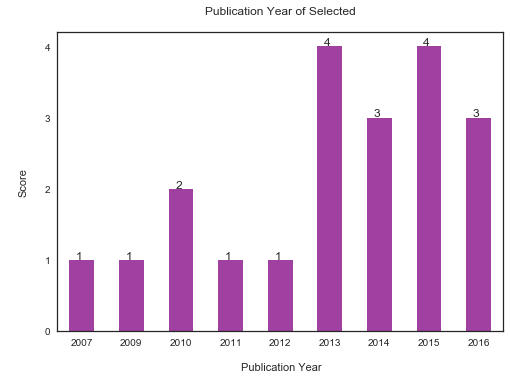

In [19]:
listayear = [work.year for work in TOTAL] # in state.related
df = pd.DataFrame (listayear)
df
df = df[[0]] 
df.columns = ['Selected']
df1 = df.sort_values('Selected', ascending=False)
df2 = df1.groupby(['Selected']).size().reset_index()
df2.sort_values('Selected', ascending=False)
df2

df2.plot.bar(x= "Selected", y=[0], color = 'purple', legend = False, alpha=0.75, rot=0)
ax = plt.gca()
ax.set_title("Publication Year of Selected\n")

ax.yaxis.set_major_locator(plt.MaxNLocator(5))

ax.grid(False)

plt.xlabel("\n Publication Year")
plt.ylabel("\nScore\n")
print ('\n \033[1m Bar Chart Publications Year - Strategy 1 \n \033[0m')

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.000, p.get_height() * 1.005 ), ha='center', va='center', xytext=(10, 3), textcoords='offset points')
 

## Strategy 2 -  Database Search + Snowballing of Wohlin Guideline (Search + SB)


 Provenance Graph - Strategy 2 - Database Search + Snowballing of Wohlin Guideline (Search + SB)


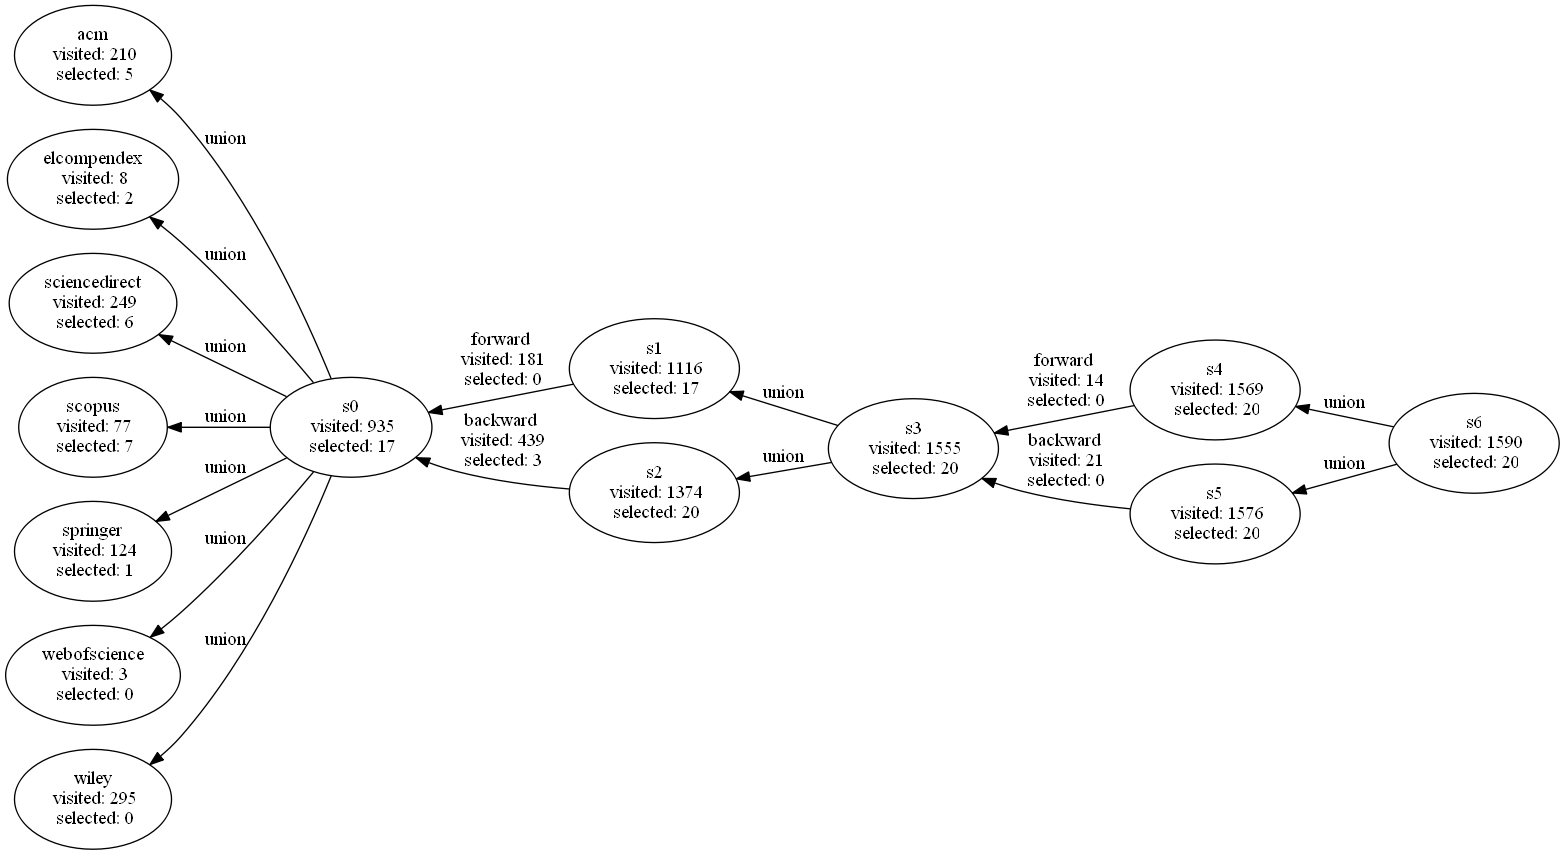

In [20]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")


strategy = busca_completa(["acm2016", "elcompendex2016", "sciencedirect2016", "scopus2016", "springer2016", "webofscience2016", "wiley2016",], filter_function)
state = strategy.sfbu()

    
final = FinalSelection(state)
print("\n \033[1mProvenance Graph - Strategy 2 - Database Search + Snowballing of Wohlin Guideline (Search + SB)\033[0m")

final.draw

In [21]:
#salvar(final, "E2final")

In [22]:
name = "Search + SB"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

#d_decimals = 4    
#for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
#      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))
#df

d_decimals = 4 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
   
    
df1 = df[["state","delta_visited", "delta_related", "precision", "recall", "fmeasure", "operation", "visited", "related", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
df1.columns = ['Digital Library/State','Delta Visited','Delta Selected','Delta Precision%', 'Delta Recall%', 'Delta F_Measure%','Operation', 'Accumulated Visited', 'Accumulated Selected','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%']

df2 = df1.loc[df['operation'] == '-']
df2 = df2.sort_values('Digital Library/State', ascending=True)

df3 = df1.loc[df['operation'] != '-']
df3 = df3.sort_values('Digital Library/State', ascending=True)

df4 = pd.concat([df2, df3], ignore_index=True)

df4_style = df4.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df4_style.format({
    'Delta Precision%': '{:,.2f}'.format,    'Delta Recall%': '{:,.2f}'.format,    'Delta F_Measure%': '{:,.2f}'.format,
    'Accumulated Precision%': '{:,.2f}'.format,    'Accumulated Recall%': '{:,.2f}'.format,    'Accumulated F_Measure%': '{:,.2f}'.format,
})
df4_style.hidden_index = True
print("\n\033[1mReport Strategy 2 - Database Search + Snowballing of Wohlin Guideline (Search + SB)\033[0m")
print("\nTotal of selected studies in the SLR = ", len(TOTAL))
print("\nPrecision = Selected/ Visited")
print("Recall = Selected/ Total of selected studies in the SLR")
print("F-Measure = Harmonic Mean of Precision and Recall")
df4_style


Report Strategy 2 - Database Search + Snowballing of Wohlin Guideline (Search + SB)

Total of selected studies in the SLR =  20

Precision = Selected/ Visited
Recall = Selected/ Total of selected studies in the SLR
F-Measure = Harmonic Mean of Precision and Recall


Digital Library/State,Delta Visited,Delta Selected,Delta Precision%,Delta Recall%,Delta F_Measure%,Operation,Accumulated Visited,Accumulated Selected,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%
acm,210,5,2.38,25.00,4.35,-,210,5,2.38,25.00,4.35
elcompendex,8,2,25.00,10.00,14.29,-,8,2,25.00,10.00,14.29
sciencedirect,249,6,2.41,30.00,4.46,-,249,6,2.41,30.00,4.46
scopus,77,7,9.09,35.00,14.43,-,77,7,9.09,35.00,14.43
springer,124,1,0.81,5.00,1.39,-,124,1,0.81,5.00,1.39
webofscience,3,0,0.00,0.00,0.00,-,3,0,0.00,0.00,0.00
wiley,295,0,0.00,0.00,0.00,-,295,0,0.00,0.00,0.00
s0,0,0,nan,0.00,0.00,union,935,17,1.82,85.00,3.56
s1,181,0,0.00,0.00,0.00,forward,1116,17,1.52,85.00,2.99
s2,439,3,0.68,15.00,1.31,backward,1374,20,1.46,100.00,2.87


In [23]:
#df2 = df[["visited", "related","accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
#df2.columns = ['Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %'] 
#indexdf = df.index[-1]
#df3 = df2.loc[df.index == indexdf]

dfa = pd.DataFrame(array)
df1 = dfa[[0, 2, 1, 7, 8, 9]].copy() 
df1.columns = ['Strategy','Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']

d_decimals = 4    
for coluna in ['Precision %', 'Recall %', 'F-Measure %']:
    df1[coluna] = df1[coluna].apply(lambda x: round(x,d_decimals)*100)

indexdf = df1.index[-1]
df3 = df1.loc[df1.index == indexdf]    
    
    
df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df3_style.format({
    'Precision %': '{:,.2f}'.format,    'Recall %': '{:,.2f}'.format,    'F-Measure %': '{:,.2f}'.format,
})

df3_style.hidden_index = True
print("\n \033[1mReport Strategy 2 - Measures of Strategy (accumulated) \033[0m")
df3_style



 Report Strategy 2 - Measures of Strategy (accumulated) 


Strategy,Visited,Selected,Precision %,Recall %,F-Measure %
Search + SB,1590,20,1.26,100.00,2.48


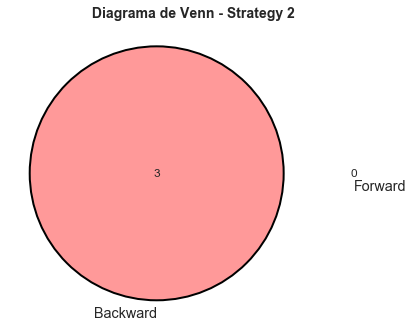

In [24]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 2',fontsize="14", fontweight="bold")
plt.show()

In [25]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['barton2009a', 'saddington2012a', 'eloranta2013a']
Forward []


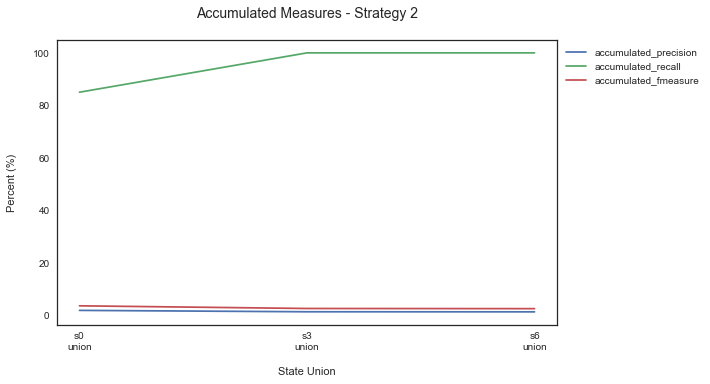

In [26]:
# ---- Grafico de linha para Somente Union 
df = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
df['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.0, 1.0))
plt.xticks(np.arange(0, len(df), 1.0), rotation='horizontal')
plt.xlabel("\nState Union")
plt.ylabel("Percent (%)\n")
ax.set_title("Accumulated Measures - Strategy 2\n", fontsize="14");
ax.grid(False)
plt.tight_layout()


## Strategy 3 - Informal Search in Google Scholar + Snowballing of Wohlin Guideline = (GS + SB)


 Provenance Graph - Strategy 3 - Informal Search in Google Scholar + Snowballing of Wohlin Guideline = (GS + SB)


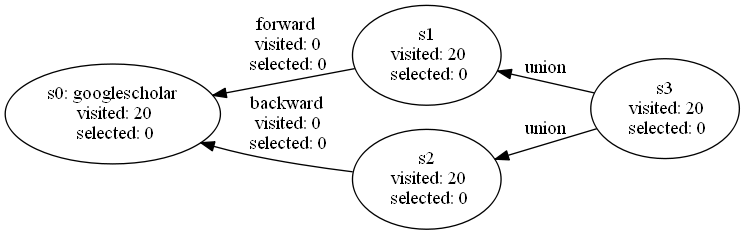

In [27]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs2016", filter_function=filter_function))
state = strategy.sfbu()

if strategy.initial.name == "s0":
    strategy.initial.name = "s0: googlescholar"

final = FinalSelection(state)
print("\n \033[1mProvenance Graph - Strategy 3 - Informal Search in Google Scholar + Snowballing of Wohlin Guideline = (GS + SB)\033[0m")

final.draw

In [28]:
#salvar(final, "E3final")

In [29]:
name = "GS + SB"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df


d_decimals = 4 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)

df1 = df[["state","delta_visited", "delta_related", "precision", "recall", "fmeasure", "operation", "visited", "related", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
df1.columns = ['Scholar=s0 /State','Delta Visited','Delta Selected','Delta Precision%', 'Delta Recall%', 'Delta F_Measure%','Operation', 'Accumulated Visited', 'Accumulated Selected','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%']

#df1 = df[["state","delta_visited", "delta_related", "precision", "recall", "fmeasure"]]
#df1.columns = ['Scholar=s0 /State','Delta Visited','Delta Selected','Delta Precision%', 'Delta Recall%', 'Delta F_Measure%']
#df1.columns = pd.MultiIndex.from_product([["Delta"],['Scholar=s0 /State','Visited','Selected','Precision%', 'Recall%', 'F_Measure%']])
#print (df1)
#
#df2 = df[["operation", "visited", "related", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
#df2.columns = ['Operation', 'Accumulated Visited', 'Accumulated Selected','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%']
#df2.columns = pd.MultiIndex.from_product([["Accumulated"],['Operation', 'Visited', 'Selected','Precision%', 'Recall%', 'F_Measure%']])
#df3 = pd.concat([df1, df2], axis=1)
#print(df3)

df1 = df1.sort_values('Scholar=s0 /State', ascending=True)

df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df1_style.format({
    'Delta Precision%': '{:,.2f}'.format,    'Delta Recall%': '{:,.2f}'.format,    'Delta F_Measure%': '{:,.2f}'.format,
    'Accumulated Precision%': '{:,.2f}'.format,    'Accumulated Recall%': '{:,.2f}'.format,    'Accumulated F_Measure%': '{:,.2f}'.format,
})

df1_style.hidden_index = True
print("\n\033[1mReport Strategy 3 - Informal Search in Google Scholar + Snowballing of Wohlin Guideline = (GS + SB)\033[0m")
print("\nTotal of selected studies in the SLR = ", len(TOTAL))
print("\nPrecision = Selected/ Visited")
print("Recall = Selected/ Total of selected studies in the SLR")
print("F-Measure = Harmonic Mean of Precision and Recall")

df1_style


Report Strategy 3 - Informal Search in Google Scholar + Snowballing of Wohlin Guideline = (GS + SB)

Total of selected studies in the SLR =  20

Precision = Selected/ Visited
Recall = Selected/ Total of selected studies in the SLR
F-Measure = Harmonic Mean of Precision and Recall


Scholar=s0 /State,Delta Visited,Delta Selected,Delta Precision%,Delta Recall%,Delta F_Measure%,Operation,Accumulated Visited,Accumulated Selected,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%
s0: googlescholar,20,0,0.00,0.00,0.00,-,20,0,0.00,0.00,0.00
s1,0,0,nan,0.00,0.00,forward,20,0,0.00,0.00,0.00
s2,0,0,nan,0.00,0.00,backward,20,0,0.00,0.00,0.00
s3,0,0,nan,0.00,0.00,union,20,0,0.00,0.00,0.00


In [30]:
#df2 = df[["visited", "related","accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
#df2.columns = ['Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']
#indexdf = df.index[-1]
#df3 = df2.loc[df.index == indexdf]

dfa = pd.DataFrame(array)
df1 = dfa[[0, 2, 1, 7, 8, 9]].copy() 
df1.columns = ['Strategy','Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']

d_decimals = 4    
for coluna in ['Precision %', 'Recall %', 'F-Measure %']:
    df1[coluna] = df1[coluna].apply(lambda x: round(x,d_decimals)*100)

indexdf = df1.index[-1]
df3 = df1.loc[df1.index == indexdf] 
    
    

df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df3_style.format({
    'Precision %': '{:,.2f}'.format,    'Recall %': '{:,.2f}'.format,    'F-Measure %': '{:,.2f}'.format,
})
df3_style.hidden_index = True
print("\n \033[1mReport Strategy 3 - Measures of Strategy (accumulated) \033[0m")
df3_style


 Report Strategy 3 - Measures of Strategy (accumulated) 


Strategy,Visited,Selected,Precision %,Recall %,F-Measure %
GS + SB,20,0,0.00,0.00,0.00


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib_venn\_venn2.py:50: UserWarning: Both circles have zero area
  warnings.warn("Both circles have zero area")


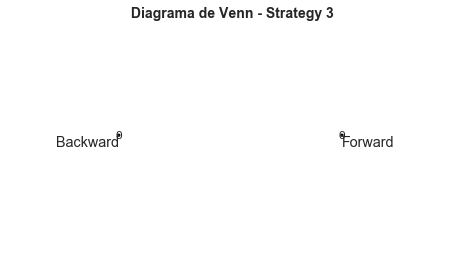

In [31]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 3',fontsize="14", fontweight="bold")
np.warnings.filterwarnings('ignore')
plt.show()

In [32]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward []
Forward []



## Strategy 4 - Scopus + Snowballing of Wohlin Guideline (Scopus + SB)


 Provenance Graph - Strategy 4 - Scopus + Snowballing of Wohlin Guideline (Scopus + SB) 


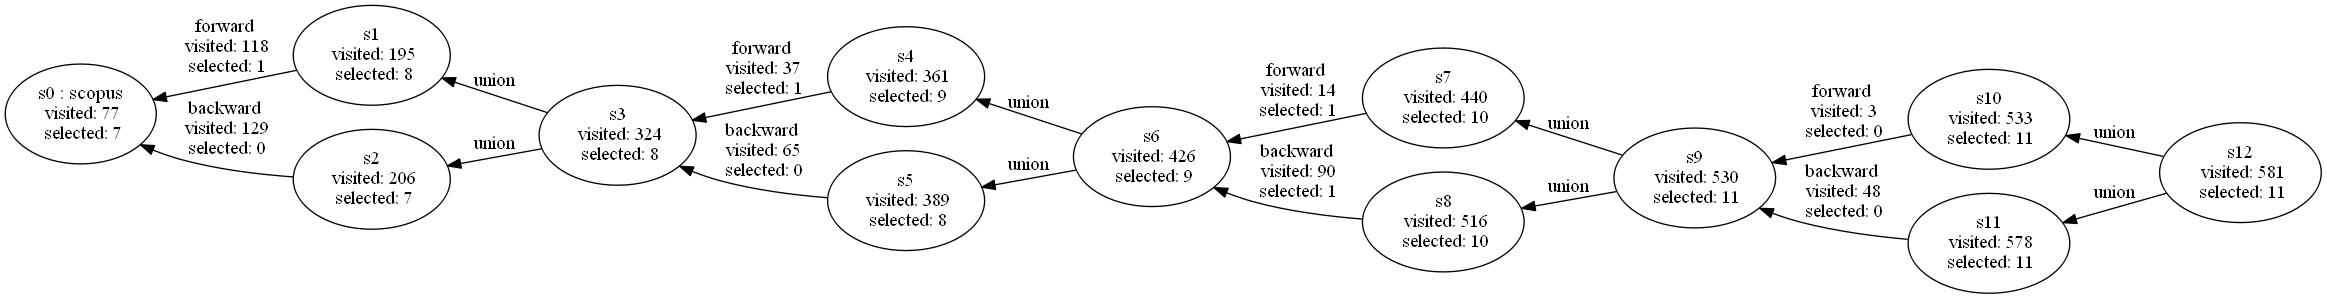

In [33]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))

state = strategy.sfbu()

if strategy.initial.name == "s0":
    strategy.initial.name = "s0 : scopus"

final = FinalSelection(state)
print("\n \033[1mProvenance Graph - Strategy 4 - Scopus + Snowballing of Wohlin Guideline (Scopus + SB) \033[0m")

final.draw

In [34]:
#salvar(final, "E4final")

In [35]:
name = "Scopus + SB"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 4 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","delta_visited", "delta_related", "precision", "recall", "fmeasure", "operation", "visited", "related", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
df1.columns = ['Scopus=s0 /State','Delta Visited','Delta Selected','Delta Precision%', 'Delta Recall%', 'Delta F_Measure%','Operation', 'Accumulated Visited', 'Accumulated Selected','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%']
                           

#df1["state2"] = df1["Scopus=s0 /State"].copy().apply(lambda x: int(x[1:3]))

df1 = df1.copy()

df1["state2"] = df1.loc[:,"Scopus=s0 /State"].copy().apply(lambda x: int(x[1:3]))
df1 = df1.sort_values('state2', ascending=True)
df1.drop('state2', axis=1, inplace=True)


df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df1_style.format({
    'Delta Precision%': '{:,.2f}'.format,    'Delta Recall%': '{:,.2f}'.format,    'Delta F_Measure%': '{:,.2f}'.format,
    'Accumulated Precision%': '{:,.2f}'.format,    'Accumulated Recall%': '{:,.2f}'.format,    'Accumulated F_Measure%': '{:,.2f}'.format,
})

df1_style.hidden_index = True

print("\n\033[1mReport Strategy 4 - Scopus + Snowballing of Wohlin Guideline (Scopus + SB)\033[0m")
print("\nTotal of selected studies in the SLR = ", len(TOTAL))
print("\nPrecision = Selected/ Visited")
print("Recall = Selected/ Total of selected studies in the SLR")
print("F-Measure = Harmonic Mean of Precision and Recall")

df1_style


Report Strategy 4 - Scopus + Snowballing of Wohlin Guideline (Scopus + SB)

Total of selected studies in the SLR =  20

Precision = Selected/ Visited
Recall = Selected/ Total of selected studies in the SLR
F-Measure = Harmonic Mean of Precision and Recall


Scopus=s0 /State,Delta Visited,Delta Selected,Delta Precision%,Delta Recall%,Delta F_Measure%,Operation,Accumulated Visited,Accumulated Selected,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%
s0 : scopus,77,7,9.09,35.00,14.43,-,77,7,9.09,35.00,14.43
s1,118,1,0.85,5.00,1.45,forward,195,8,4.10,40.00,7.44
s2,129,0,0.00,0.00,0.00,backward,206,7,3.40,35.00,6.19
s3,0,0,nan,0.00,0.00,union,324,8,2.47,40.00,4.65
s4,37,1,2.70,5.00,3.51,forward,361,9,2.49,45.00,4.72
s5,65,0,0.00,0.00,0.00,backward,389,8,2.06,40.00,3.91
s6,0,0,nan,0.00,0.00,union,426,9,2.11,45.00,4.04
s7,14,1,7.14,5.00,5.88,forward,440,10,2.27,50.00,4.35
s8,90,1,1.11,5.00,1.82,backward,516,10,1.94,50.00,3.73
s9,0,0,nan,0.00,0.00,union,530,11,2.08,55.00,4.00


In [36]:
#df2 = df[["visited", "related","accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
#df2.columns = ['Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']
#indexdf = df.index[-1]
#df3 = df2.loc[df.index == indexdf]

dfa = pd.DataFrame(array)
df1 = dfa[[0, 2, 1, 7, 8, 9]].copy() 
df1.columns = ['Strategy','Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']

d_decimals = 4    
for coluna in ['Precision %', 'Recall %', 'F-Measure %']:
    df1[coluna] = df1[coluna].apply(lambda x: round(x,d_decimals)*100)

indexdf = df1.index[-1]
df3 = df1.loc[df1.index == indexdf] 


df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df3_style.format({
    'Precision %': '{:,.2f}'.format,    'Recall %': '{:,.2f}'.format,    'F-Measure %': '{:,.2f}'.format,
})

df3_style.hidden_index = True
print("\n \033[1mReport Strategy 4 - Measures of Strategy (accumulated) \033[0m")
df3_style


 Report Strategy 4 - Measures of Strategy (accumulated) 


Strategy,Visited,Selected,Precision %,Recall %,F-Measure %
Scopus + SB,581,11,1.89,55.00,3.66


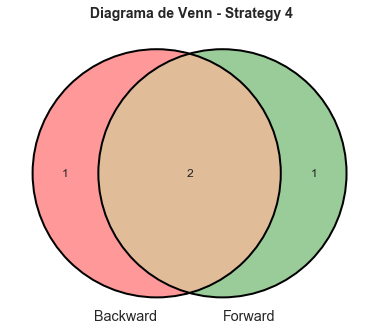

In [37]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 4',fontsize="14", fontweight="bold")
plt.show()

In [38]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['waardenburg2013a', 'saddington2012a', 'vlietland2015a']
Forward ['waardenburg2013a', 'vlietland2016a', 'vlietland2015a']


## Strategy 5 - Scopus + Parallel Snowballing of Paper ESEM2017 (Scopus + BS // FS)


 Provenance Graph - Strategy 5 - Scopus + Parallel Snowballing of Paper ESEM2017 (Scopus + BS // FS) 


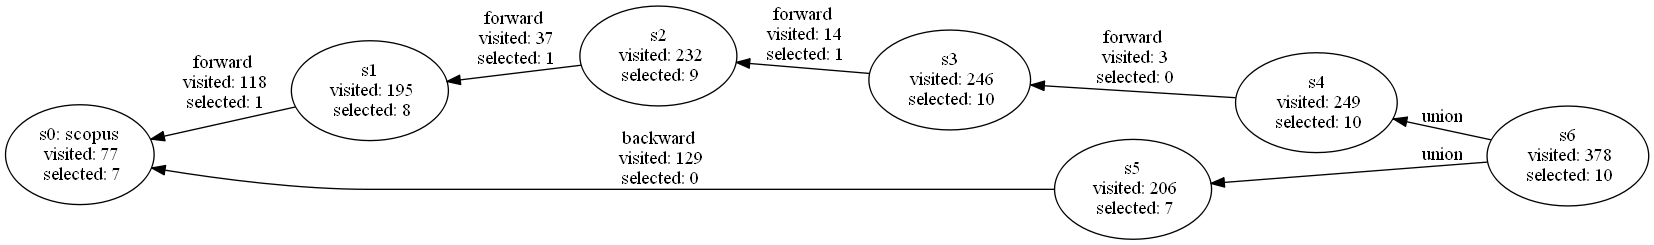

In [39]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))
state = strategy.s2bbff2u()

if strategy.initial.name == "s0":
    strategy.initial.name = "s0: scopus"
final = FinalSelection(state)   
print("\n \033[1mProvenance Graph - Strategy 5 - Scopus + Parallel Snowballing of Paper ESEM2017 (Scopus + BS // FS) \033[0m")

final.draw

In [40]:
#salvar(final, "E5final")

In [41]:
name = "Scopus + BS // FS"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 4 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)

df1 = df[["state","delta_visited", "delta_related", "precision", "recall", "fmeasure", "operation", "visited", "related", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
df1.columns = ['Scopus=s0 /State','Delta Visited','Delta Selected','Delta Precision%', 'Delta Recall%', 'Delta F_Measure%','Operation', 'Accumulated Visited', 'Accumulated Selected','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%']

df1 = df1.sort_values('Scopus=s0 /State', ascending=True)
   
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df1_style.format({
    'Delta Precision%': '{:,.2f}'.format,    'Delta Recall%': '{:,.2f}'.format,    'Delta F_Measure%': '{:,.2f}'.format,
    'Accumulated Precision%': '{:,.2f}'.format,    'Accumulated Recall%': '{:,.2f}'.format,    'Accumulated F_Measure%': '{:,.2f}'.format,
})

df1_style.hidden_index = True
print("\n\033[1mReport Strategy 5 - Scopus + Parallel Snowballing of Paper ESEM2017 (Scopus + BS // FS)\033[0m")
print("\nTotal of selected studies in the SLR = ", len(TOTAL))
print("\nPrecision = Selected/ Visited")
print("Recall = Selected/ Total of selected studies in the SLR")
print("F-Measure = Harmonic Mean of Precision and Recall")

df1_style



Report Strategy 5 - Scopus + Parallel Snowballing of Paper ESEM2017 (Scopus + BS // FS)

Total of selected studies in the SLR =  20

Precision = Selected/ Visited
Recall = Selected/ Total of selected studies in the SLR
F-Measure = Harmonic Mean of Precision and Recall


Scopus=s0 /State,Delta Visited,Delta Selected,Delta Precision%,Delta Recall%,Delta F_Measure%,Operation,Accumulated Visited,Accumulated Selected,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%
s0: scopus,77,7,9.09,35.00,14.43,-,77,7,9.09,35.00,14.43
s1,118,1,0.85,5.00,1.45,forward,195,8,4.10,40.00,7.44
s2,37,1,2.70,5.00,3.51,forward,232,9,3.88,45.00,7.14
s3,14,1,7.14,5.00,5.88,forward,246,10,4.07,50.00,7.52
s4,3,0,0.00,0.00,0.00,forward,249,10,4.02,50.00,7.43
s5,129,0,0.00,0.00,0.00,backward,206,7,3.40,35.00,6.19
s6,0,0,nan,0.00,0.00,union,378,10,2.65,50.00,5.03


In [42]:
#df2 = df[["visited", "related","accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
#df2.columns = ['Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']
#indexdf = df.index[-1]
#df3 = df2.loc[df.index == indexdf]

dfa = pd.DataFrame(array)
df1 = dfa[[0, 2, 1, 7, 8, 9]].copy() 
df1.columns = ['Strategy','Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']

d_decimals = 4    
for coluna in ['Precision %', 'Recall %', 'F-Measure %']:
    df1[coluna] = df1[coluna].apply(lambda x: round(x,d_decimals)*100)

indexdf = df1.index[-1]
df3 = df1.loc[df1.index == indexdf] 

df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df3_style.format({
    'Precision %': '{:,.2f}'.format,    'Recall %': '{:,.2f}'.format,    'F-Measure %': '{:,.2f}'.format,
})

df3_style.hidden_index = True
print("\n \033[1mReport Strategy 5 - Measures of Strategy (accumulated) \033[0m")
df3_style


 Report Strategy 5 - Measures of Strategy (accumulated) 


Strategy,Visited,Selected,Precision %,Recall %,F-Measure %
Scopus + BS // FS,378,10,2.65,50.00,5.03


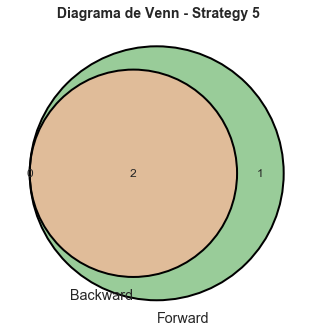

In [43]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 5',fontsize="14", fontweight="bold")
plt.show()

In [44]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['waardenburg2013a', 'vlietland2015a']
Forward ['waardenburg2013a', 'vlietland2016a', 'vlietland2015a']



  Bar Chart Strategy 5 


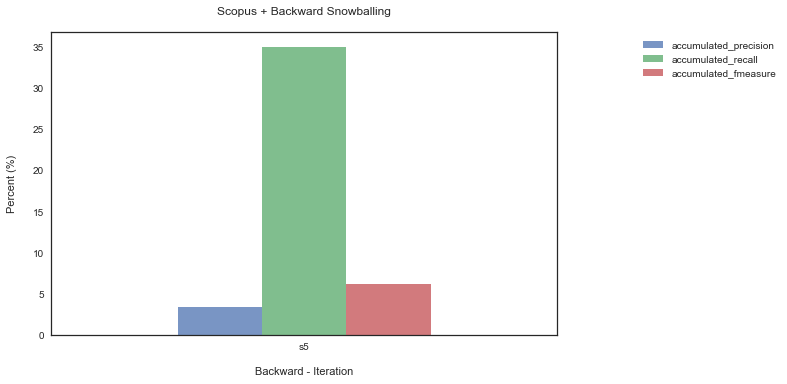

In [45]:
df1 = df.loc[df['operation'] == 'backward']

df1.plot.bar(y=["accumulated_precision","accumulated_recall","accumulated_fmeasure"],alpha=0.75, rot=0)
ax = plt.gca()
ax.set_title("Scopus + Backward Snowballing\n")
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.45, 1.0))
ax.set_xticklabels(df1["state"])
plt.xlabel("\nBackward - Iteration")
plt.ylabel("Percent (%)\n")
ax.grid(False)
print ('\n \033[1m Bar Chart Strategy 5 \033[0m')

plt.tight_layout()


  Bar Chart Strategy 5 


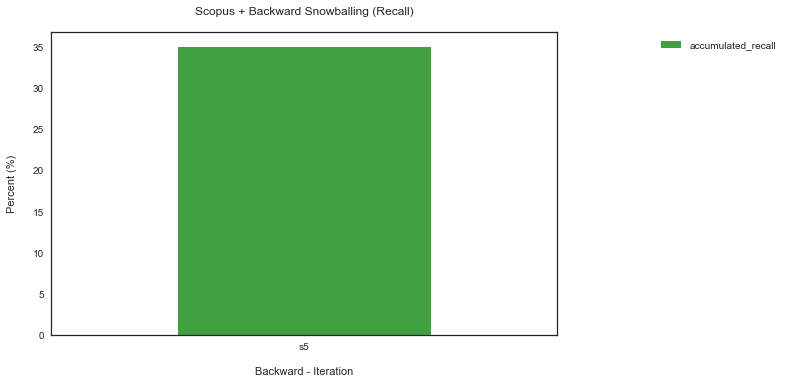

In [46]:
df1 = df.loc[df['operation'] == 'backward'] 

df1.plot.bar(y=["accumulated_recall"],color = 'green', alpha=0.75, rot=0)
ax = plt.gca()
ax.set_title("Scopus + Backward Snowballing (Recall)\n")
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.45, 1.0))
ax.set_xticklabels(df1["state"])
plt.xlabel("\nBackward - Iteration")
plt.ylabel("Percent (%)\n")
ax.grid(False)
print ('\n \033[1m Bar Chart Strategy 5 \033[0m')

plt.tight_layout()


  Bar Chart Strategy 5 


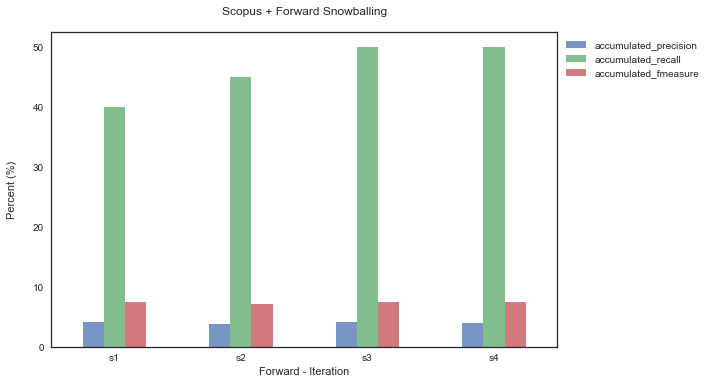

In [47]:
df2 = df.loc[df['operation'] == 'forward'].reset_index(drop=True)

df2.plot.bar(y=["accumulated_precision","accumulated_recall","accumulated_fmeasure"], alpha=0.75, rot=0)
ax = plt.gca()
ax.set_title("Scopus + Forward Snowballing\n")
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.0, 1.0))
ax.set_xticklabels(df2["state"])
plt.xlabel("Forward - Iteration")
plt.ylabel("Percent (%)\n")
ax.grid(False)
print ('\n \033[1m Bar Chart Strategy 5 \033[0m')

plt.tight_layout()



  Bar Chart Strategy 5 


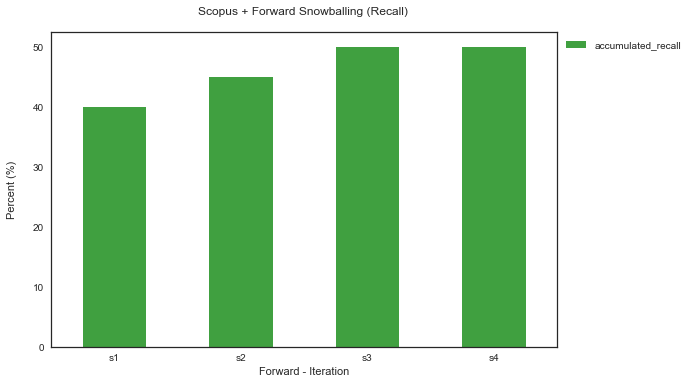

In [48]:
df2 = df.loc[df['operation'] == 'forward'].reset_index(drop=True)

df2.plot.bar(y=["accumulated_recall"], color='green', alpha=0.75, rot=0)
ax = plt.gca()
ax.set_title("Scopus + Forward Snowballing (Recall) \n")
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.0, 1.0))
ax.set_xticklabels(df2["state"])
plt.xlabel("Forward - Iteration")
plt.ylabel("Percent (%)\n")
ax.grid(False)
print ('\n \033[1m Bar Chart Strategy 5 \033[0m')

plt.tight_layout()


## Strategy 6 - Scopus + Sequential Snowballing (Scopus + BS + FS)


 Provenance Graph - Strategy 6 - Scopus + Sequential Snowballing (Scopus + BS + FS) 


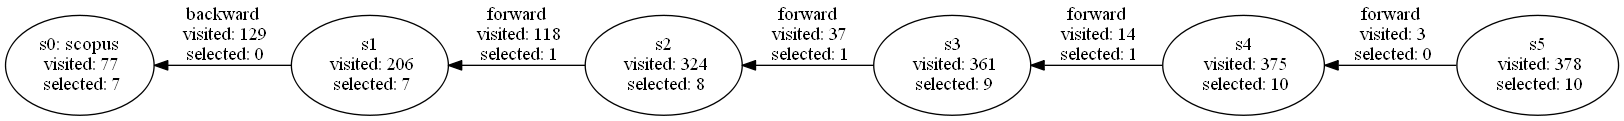

In [49]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))
state = strategy.bbff()

if strategy.initial.name == "s0":
    strategy.initial.name = "s0: scopus"
final =  FinalSelection(state)  
print("\n \033[1mProvenance Graph - Strategy 6 - Scopus + Sequential Snowballing (Scopus + BS + FS) \033[0m")

final.draw

In [50]:
#salvar(final, "E6final")

In [51]:
name = "Scopus + BS + FS"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 4 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","delta_visited", "delta_related", "precision", "recall", "fmeasure", "operation", "visited", "related", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
df1.columns = ['Scopus=s0 /State','Delta Visited','Delta Selected','Delta Precision%', 'Delta Recall%', 'Delta F_Measure%','Operation', 'Accumulated Visited', 'Accumulated Selected','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%']

df1 = df1.sort_values('Scopus=s0 /State', ascending=True)

df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df1_style.format({
    'Delta Precision%': '{:,.2f}'.format,    'Delta Recall%': '{:,.2f}'.format,    'Delta F_Measure%': '{:,.2f}'.format,
    'Accumulated Precision%': '{:,.2f}'.format,    'Accumulated Recall%': '{:,.2f}'.format,    'Accumulated F_Measure%': '{:,.2f}'.format,
})

df1_style.hidden_index = True
#print (strategy_row)
print("\n\033[1mReport Strategy 6 - Scopus + Sequential Snowballing (Scopus + BS + FS)\033[0m")
print("\nTotal of selected studies in the SLR = ", len(TOTAL))
print("\nPrecision = Selected/ Visited")
print("Recall = Selected/ Total of selected studies in the SLR")
print("F-Measure = Harmonic Mean of Precision and Recall")

df1_style


Report Strategy 6 - Scopus + Sequential Snowballing (Scopus + BS + FS)

Total of selected studies in the SLR =  20

Precision = Selected/ Visited
Recall = Selected/ Total of selected studies in the SLR
F-Measure = Harmonic Mean of Precision and Recall


Scopus=s0 /State,Delta Visited,Delta Selected,Delta Precision%,Delta Recall%,Delta F_Measure%,Operation,Accumulated Visited,Accumulated Selected,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%
s0: scopus,77,7,9.09,35.00,14.43,-,77,7,9.09,35.00,14.43
s1,129,0,0.00,0.00,0.00,backward,206,7,3.40,35.00,6.19
s2,118,1,0.85,5.00,1.45,forward,324,8,2.47,40.00,4.65
s3,37,1,2.70,5.00,3.51,forward,361,9,2.49,45.00,4.72
s4,14,1,7.14,5.00,5.88,forward,375,10,2.67,50.00,5.06
s5,3,0,0.00,0.00,0.00,forward,378,10,2.65,50.00,5.03


In [52]:
#df2 = df[["visited", "related","accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
#df2.columns = ['Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']
#indexdf = df.index[-1]
#df3 = df2.loc[df.index == indexdf]

dfa = pd.DataFrame(array)
df1 = dfa[[0, 2, 1, 7, 8, 9]].copy() 
df1.columns = ['Strategy','Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']

d_decimals = 4    
for coluna in ['Precision %', 'Recall %', 'F-Measure %']:
    df1[coluna] = df1[coluna].apply(lambda x: round(x,d_decimals)*100)

indexdf = df1.index[-1]
df3 = df1.loc[df1.index == indexdf] 


df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df3_style.format({
    'Precision %': '{:,.2f}'.format,    'Recall %': '{:,.2f}'.format,    'F-Measure %': '{:,.2f}'.format,
})
df3_style.hidden_index = True
print("\n \033[1mReport Strategy 6 - Measures of Strategy (accumulated) \033[0m")
df3_style


 Report Strategy 6 - Measures of Strategy (accumulated) 


Strategy,Visited,Selected,Precision %,Recall %,F-Measure %
Scopus + BS + FS,378,10,2.65,50.00,5.03


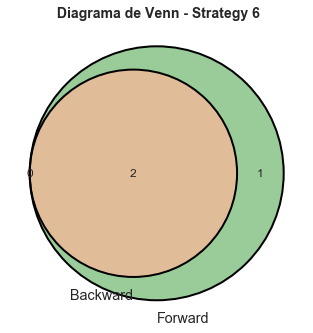

In [53]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 6',fontsize="14", fontweight="bold")
plt.show()

In [54]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['waardenburg2013a', 'vlietland2015a']
Forward ['waardenburg2013a', 'vlietland2016a', 'vlietland2015a']


## Strategy 7 - Scopus + Sequential Snowballing  (Scopus + FS + BS)


 Provenance Graph - Strategy 7 - Scopus + Sequential Snowballing (Scopus + FS + BS) 


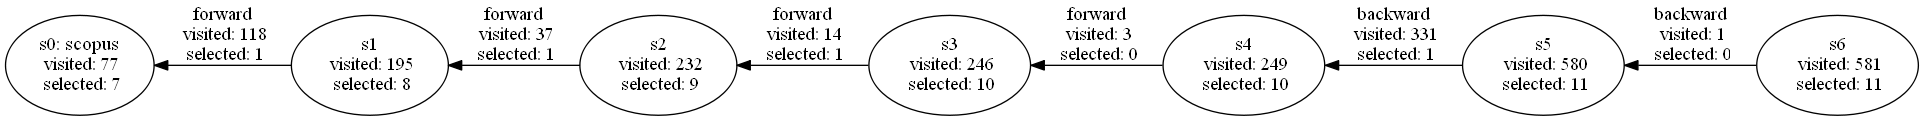

In [55]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))
state = strategy.ffbb()

if strategy.initial.name == "s0":
    strategy.initial.name = "s0: scopus"
final = FinalSelection(state)
print("\n \033[1mProvenance Graph - Strategy 7 - Scopus + Sequential Snowballing (Scopus + FS + BS) \033[0m")

final.draw

In [56]:
#salvar(final, "E7final")

In [57]:
name = "Scopus + FS + BS"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 4 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","delta_visited", "delta_related", "precision", "recall", "fmeasure", "operation", "visited", "related", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
df1.columns = ['Scopus=s0 /State','Delta Visited','Delta Selected','Delta Precision%', 'Delta Recall%', 'Delta F_Measure%','Operation', 'Accumulated Visited', 'Accumulated Selected','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%']

df1 = df1.sort_values('Scopus=s0 /State', ascending=True)
   
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df1_style.format({
    'Delta Precision%': '{:,.2f}'.format,    'Delta Recall%': '{:,.2f}'.format,    'Delta F_Measure%': '{:,.2f}'.format,
    'Accumulated Precision%': '{:,.2f}'.format,    'Accumulated Recall%': '{:,.2f}'.format,    'Accumulated F_Measure%': '{:,.2f}'.format,
})


df1_style.hidden_index = True
print("\n\033[1mReport Strategy 7 - Scopus + Sequential Snowballing (Scopus + FS + BS)\033[0m")
print("\nTotal of selected studies in the SLR = ", len(TOTAL))
print("\nPrecision = Selected/ Visited")
print("Recall = Selected/ Total of selected studies in the SLR")
print("F-Measure = Harmonic Mean of Precision and Recall")
#print (strategy_row)
df1_style



Report Strategy 7 - Scopus + Sequential Snowballing (Scopus + FS + BS)

Total of selected studies in the SLR =  20

Precision = Selected/ Visited
Recall = Selected/ Total of selected studies in the SLR
F-Measure = Harmonic Mean of Precision and Recall


Scopus=s0 /State,Delta Visited,Delta Selected,Delta Precision%,Delta Recall%,Delta F_Measure%,Operation,Accumulated Visited,Accumulated Selected,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%
s0: scopus,77,7,9.09,35.00,14.43,-,77,7,9.09,35.00,14.43
s1,118,1,0.85,5.00,1.45,forward,195,8,4.10,40.00,7.44
s2,37,1,2.70,5.00,3.51,forward,232,9,3.88,45.00,7.14
s3,14,1,7.14,5.00,5.88,forward,246,10,4.07,50.00,7.52
s4,3,0,0.00,0.00,0.00,forward,249,10,4.02,50.00,7.43
s5,331,1,0.30,5.00,0.57,backward,580,11,1.90,55.00,3.67
s6,1,0,0.00,0.00,0.00,backward,581,11,1.89,55.00,3.66


In [58]:
#df2 = df[["visited", "related","accumulated_precision", "accumulated_recall", "accumulated_fmeasure"]]
#df2.columns = ['Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']
#indexdf = df.index[-1]
#df3 = df2.loc[df.index == indexdf]

dfa = pd.DataFrame(array)
df1 = dfa[[0, 2, 1, 7, 8, 9]].copy() 
df1.columns = ['Strategy','Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']

d_decimals = 4    
for coluna in ['Precision %', 'Recall %', 'F-Measure %']:
    df1[coluna] = df1[coluna].apply(lambda x: round(x,d_decimals)*100)

indexdf = df1.index[-1]
df3 = df1.loc[df1.index == indexdf] 


df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df3_style.format({
    'Precision %': '{:,.2f}'.format,    'Recall %': '{:,.2f}'.format,    'F-Measure %': '{:,.2f}'.format,
})

df3_style.hidden_index = True
print("\n \033[1mReport Strategy 7 - Measures of Strategy (accumulated) \033[0m")
df3_style


 Report Strategy 7 - Measures of Strategy (accumulated) 


Strategy,Visited,Selected,Precision %,Recall %,F-Measure %
Scopus + FS + BS,581,11,1.89,55.00,3.66


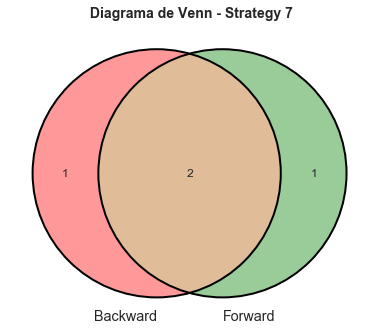

In [59]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 7',fontsize="14", fontweight="bold")
plt.show()

In [60]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['waardenburg2013a', 'saddington2012a', 'vlietland2015a']
Forward ['waardenburg2013a', 'vlietland2016a', 'vlietland2015a']


# Analyses

In [61]:
%matplotlib inline
import pandas as pd

In [62]:
df = pd.DataFrame (array)
#Esse array possui elementos do (11 ate o 23) 11o elem. até o último elem. pq estamos incluindo desde a Estrategia 1 somente esses elementos em strategy_row = [name] + last[11:].
#df.columns = ['name','related','visited','final_selected','excel','excel_selected','duplicated','accumulated_precision', 'accumulated_recall','accumulated_fmeasure','final_accumulated_precision','final_accumulated_recall','final_accumulated_fmeasure']
#df.index = df['Estratégia']
#df

df1 = df[[0, 2, 1, 7, 8, 9]].copy()  #seleção de somente alguns elementos do df do array, com posições diferentes 

df1.columns = ['Strategy','Visited', 'Selected','Precision %', 'Recall %', 'F-Measure %']

#df1.set_index("Strategy", inplace=True)

d_decimals = 4    
for coluna in ['Precision %', 'Recall %', 'F-Measure %']:
    df1[coluna] = df1[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df1[coluna] = df1[coluna].map('{:,.2f}'.format)

    
df1_style = (
    df1.style
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        dict(selector="th", props=[("text-align", "center")]),
    ])
)
df1_style.format({
    'Precision %': '{:,.2f}'.format,    'Recall %': '{:,.2f}'.format,    'F-Measure %': '{:,.2f}'.format,
})

dfEAll=df1
df1_style.hidden_index = True
df1_style


Strategy,Visited,Selected,Precision %,Recall %,F-Measure %
Search,935,17,1.82,85.00,3.56
Search + SB,1590,20,1.26,100.00,2.48
GS + SB,20,0,0.00,0.00,0.00
Scopus + SB,581,11,1.89,55.00,3.66
Scopus + BS // FS,378,10,2.65,50.00,5.03
Scopus + BS + FS,378,10,2.65,50.00,5.03
Scopus + FS + BS,581,11,1.89,55.00,3.66



  Bar Chart Strategies 


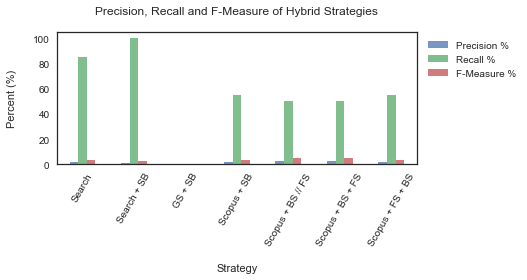

In [63]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df1.loc[:, df1.columns.difference(exclude)].plot.bar(y=['Precision %', 'Recall %', 'F-Measure %'],alpha=0.75, rot=60 )
ax.set_title("Precision, Recall and F-Measure of Hybrid Strategies\n")
ax.set_xticklabels(df1['Strategy'])
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.3, 1.0))
plt.xlabel("\nStrategy")
plt.ylabel("Percent (%)\n")
plt.tight_layout()

print ('\n \033[1m Bar Chart Strategies \033[0m')


  Bar Chart Strategies 


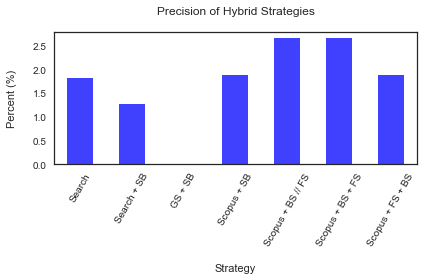

In [64]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df1.loc[:, df1.columns.difference(exclude)].plot.bar(y=['Precision %'], color = "blue", alpha=0.75, rot=60 )
ax.set_title("Precision of Hybrid Strategies\n")
ax.set_xticklabels(df1['Strategy'])
ax.legend_.remove()
plt.xlabel("\nStrategy")
plt.ylabel("Percent (%)\n")
plt.tight_layout()

print ('\n \033[1m Bar Chart Strategies \033[0m')


  Bar Chart Strategies 


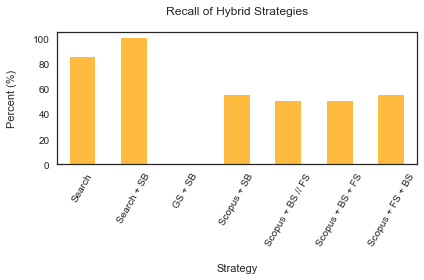

In [65]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df1.loc[:, df1.columns.difference(exclude)].plot.bar(y=['Recall %'], color = "orange", alpha=0.75, rot=60 )
ax.set_title("Recall of Hybrid Strategies\n")
ax.set_xticklabels(df1['Strategy'])
ax.legend_.remove()
plt.xlabel("\nStrategy")
plt.ylabel("Percent (%)\n")
plt.tight_layout()

print ('\n \033[1m Bar Chart Strategies \033[0m')


  Bar Chart Strategies 


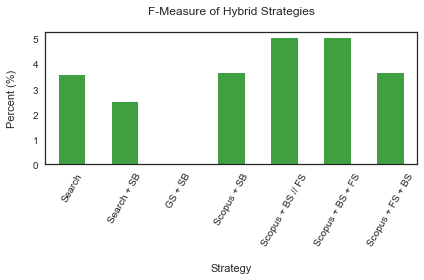

In [66]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df1.loc[:, df1.columns.difference(exclude)].plot.bar(y=['F-Measure %'], color = "green", alpha=0.75, rot=60 )
ax.set_title("F-Measure of Hybrid Strategies\n")
ax.set_xticklabels(df1['Strategy'])
ax.legend_.remove()
plt.xlabel("\nStrategy")
plt.ylabel("Percent (%)\n")
plt.tight_layout()

print ('\n \033[1m Bar Chart Strategies \033[0m')

In [67]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

In [68]:
#len ({x for _, x in load_work_map_all_years() if x.category == "snowball"})
#{x for _, x in load_work_map_all_years() if x.category == "snowball"} @ metakey_title

# Research Questions

In [69]:
print ("\nRQ1) Which of the digital libraries used in the published SLR is more efficient?")

#RQ1.1) Qual busca em biblioteca digital encontra mais artigos incluídos na lista de selecionados da SLR 
#publicada dentre o resultado retornado na busca (Precision)?
#RQ1.2) Qual busca em biblioteca digital recupera todos os artigos que estavam incluídos na lista de 
#selecionados da SRL publicada (Recall)?
#RQ1.3) Qual biblioteca digital apresenta melhor média harmônica (F-Measure)?
#dfE1

dfE1r

df1_style = dfE1r.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df1_style.format({
    'Precision %': '{:,.2f}'.format,    'Recall %': '{:,.2f}'.format,    'F-Measure %': '{:,.2f}'.format,
})

df1_style.hidden_index = True
df1_style


RQ1) Which of the digital libraries used in the published SLR is more efficient?


Digital Library,Visited,Selected,Precision %,Recall %,F-Measure %
acm,210,5,2.38,25.00,4.35
elcompendex,8,2,25.00,10.00,14.29
sciencedirect,249,6,2.41,30.00,4.46
scopus,77,7,9.09,35.00,14.43
springer,124,1,0.81,5.00,1.39
webofscience,3,0,0.00,0.00,0.00
wiley,295,0,0.00,0.00,0.00


In [70]:
print ("\nRQ2) Which of the hybrid strategies is more efficient?")

#RQ2.1)A estratégia híbrida envolve analisar menos artigos quando comparada 
#com as SLRs publicadas que conduziram buscas somente em bases de dados? Precision.
#RQ2.2)A estratégia híbrida recupera todos os artigos que estavam incluídos 
#na SLR publicada que conduziu as buscas em bases de dados? Recall.
#RQ2.3)Qual estratégia híbrida apresenta melhor média harmônica? F-measure.

dfEAll

df1 = dfEAll.drop(dfEAll.index[[0]])

exclude = ['Visited', 'Related', 'Final Selected']
df1 = df1.loc[:, dfEAll.columns.difference(exclude)]

df2 = df1[['Strategy','Precision %', 'Recall %', 'F-Measure %']]      
df2.columns = ['Strategy','Precision %', 'Recall %', 'F-Measure %']
df1_style = df2.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])

df1_style.format({
    'Precision %': '{:,.2f}'.format,    'Recall %': '{:,.2f}'.format,    'F-Measure %': '{:,.2f}'.format,
})

df1_style.hidden_index = True
df1_style




RQ2) Which of the hybrid strategies is more efficient?


Strategy,Precision %,Recall %,F-Measure %
Search + SB,1.26,100.00,2.48
GS + SB,0.00,0.00,0.00
Scopus + SB,1.89,55.00,3.66
Scopus + BS // FS,2.65,50.00,5.03
Scopus + BS + FS,2.65,50.00,5.03
Scopus + FS + BS,1.89,55.00,3.66


In [71]:
print ("\nRQ3) Which of the strategies is more efficient?")

#RQ3.1)A estratégia envolve analisar menos artigos quando comparada 
#com as SLRs publicadas que conduziram buscas somente em bases de dados? Precision.
#RQ3.2)A estratégia recupera todos os artigos que estavam incluídos 
#na SLR publicada que conduziu as buscas em bases de dados? Recall.
#RQ3.3) Qual estratégia apresenta melhor média harmônica? F-measure.

dfEAll
exclude = ['Visited', 'Related', 'Final Selected']
df1 = dfEAll.loc[:, dfEAll.columns.difference(exclude)]
df2 = df1[['Strategy','Precision %', 'Recall %', 'F-Measure %']]      
df2.columns = ['Strategy','Precision %', 'Recall %', 'F-Measure %']
df1_style = df2.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style.format({
    'Precision %': '{:,.2f}'.format,    'Recall %': '{:,.2f}'.format,    'F-Measure %': '{:,.2f}'.format,
})
df1_style.hidden_index = True
df1_style


RQ3) Which of the strategies is more efficient?


Strategy,Precision %,Recall %,F-Measure %
Search,1.82,85.00,3.56
Search + SB,1.26,100.00,2.48
GS + SB,0.00,0.00,0.00
Scopus + SB,1.89,55.00,3.66
Scopus + BS // FS,2.65,50.00,5.03
Scopus + BS + FS,2.65,50.00,5.03
Scopus + FS + BS,1.89,55.00,3.66


In [72]:
print ("\nRQ4) How many selected articles does the digital library find through the direct search for the title of the article?")
df = pd.DataFrame (arraysearch)
df1 = df[[0, 1]] 
df1.columns = ['Digital Library','Recall %']

df1 = df1.sort_values('Digital Library', ascending=True)

d_decimals = 4    
for coluna in ['Recall %']:
    df1[coluna] = df1[coluna].apply(lambda x: round(x,d_decimals)*100)

df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style.format({
    'Recall %': '{:,.2f}'.format,
})
df1_style.hidden_index = True
df1_style


RQ4) How many selected articles does the digital library find through the direct search for the title of the article?


Digital Library,Recall %
acm,25.00
elcompendex,95.00
sciencedirect,30.00
scopus,95.00
springer,10.00
webofscience,55.00
wiley,0.00
